# Melanoma Detection Assignment

### Importing required libraries

In [23]:
import pathlib
import tensorflow as tf  #Version: 2.17.0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Normalization, StringLookup,RandomFlip,RandomRotation,RandomZoom



- This assignment uses a dataset of about 2357 images of skin cancer types. 
- It contains 9 sub-directories in each train and test subdirectories.
- The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
data_dir_train = pathlib.Path("./CNN_assignment/Train/")
data_dir_test = pathlib.Path("./CNN_assignment/Test/")

In [ ]:
## Count total images for training and test

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

We can use 80% of the images for training purpose and 20% for validation.

In [5]:

## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

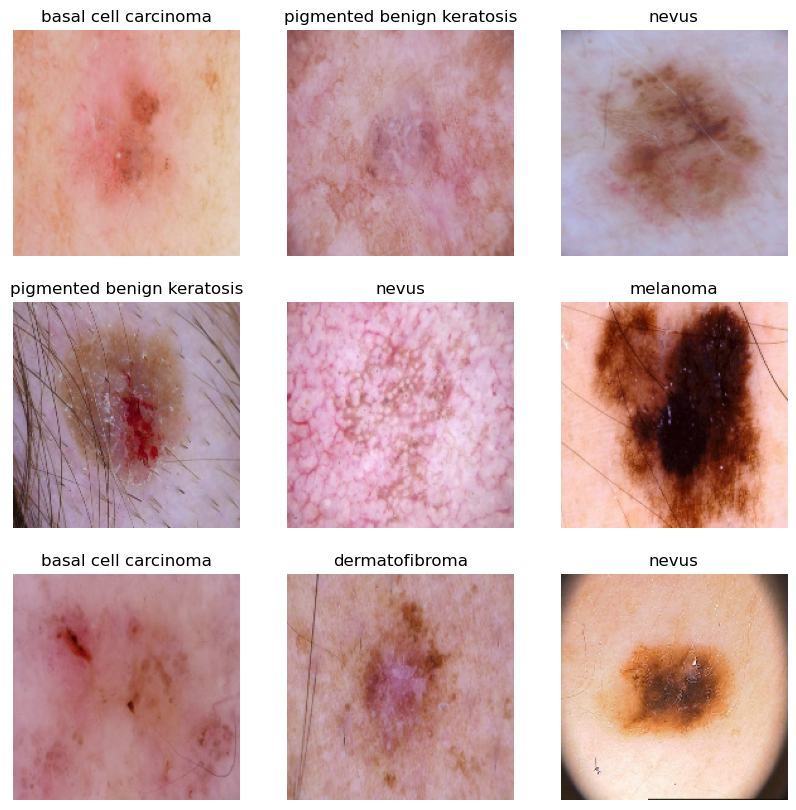

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. 
Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 

The RGB channel values are in the `[0, 255]` range. 
This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:

num_classes = 9

model = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



/Users/dwevedi/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [18]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.2026 - loss: 2.2095 - val_accuracy: 0.2707 - val_loss: 1.8730
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.3324 - loss: 1.8192 - val_accuracy: 0.4027 - val_loss: 1.7266
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.4177 - loss: 1.6685 - val_accuracy: 0.4899 - val_loss: 1.5386
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.4774 - loss: 1.4667 - val_accuracy: 0.5123 - val_loss: 1.4443
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.5317 - loss: 1.3546 - val_accuracy: 0.4877 - val_loss: 1.4940
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.5447 - loss: 1.2568 - val_accuracy: 0.4720 - val_loss: 1.4881
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.5751 - loss: 1.1989 - val_accuracy: 0.5459 - val_loss: 1.2836
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.6248 - loss: 1.0545 - val_accuracy: 0

### Visualizing training results

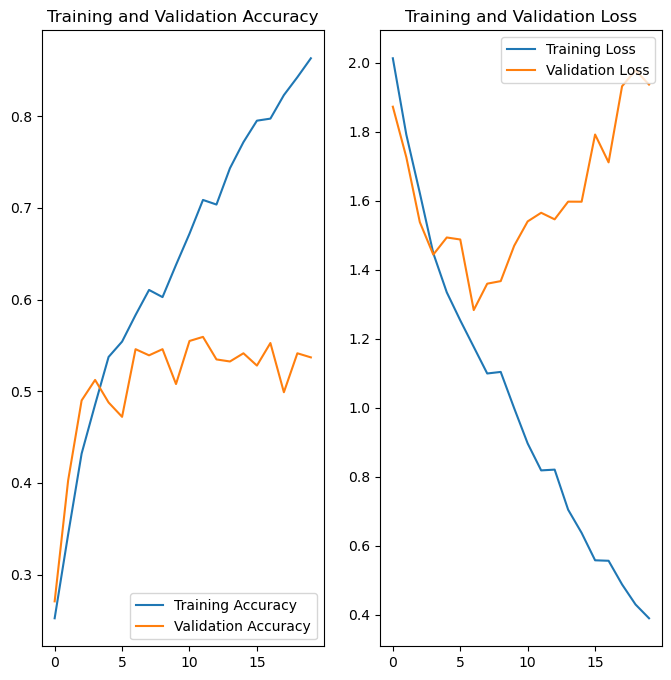

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [25]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

2024-09-30 22:19:26.741685: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


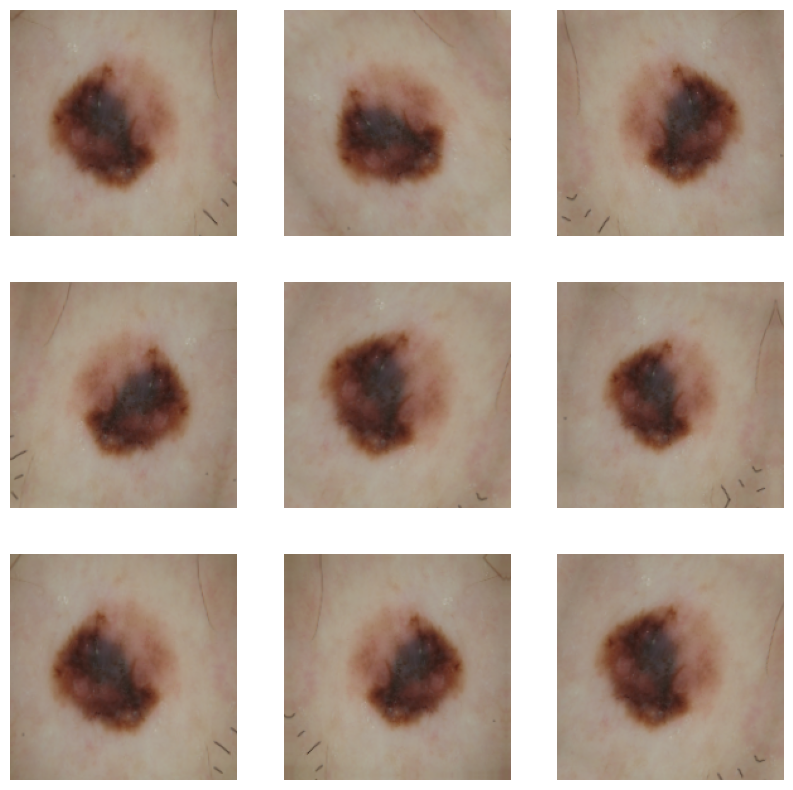

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [28]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [29]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [30]:
## training model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.1751 - loss: 2.3996 - val_accuracy: 0.2304 - val_loss: 2.0307
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.2411 - loss: 1.9968 - val_accuracy: 0.3065 - val_loss: 1.8813
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.3133 - loss: 1.8630 - val_accuracy: 0.3691 - val_loss: 1.6918
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.3787 - loss: 1.6655 - val_accuracy: 0.4161 - val_loss: 1.6569
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.4279 - loss: 1.5678 - val_accuracy: 0.5034 - val_loss: 1.4659
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.4713 - loss: 1.4769 - val_accuracy: 0.4743 - val_loss: 1.5221
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.5008 - loss: 1.3972 - val_accuracy: 0.5436 - val_loss: 1.3610
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.5270 - loss: 1.3337 - val_accuracy: 0.

### Visualizing the results

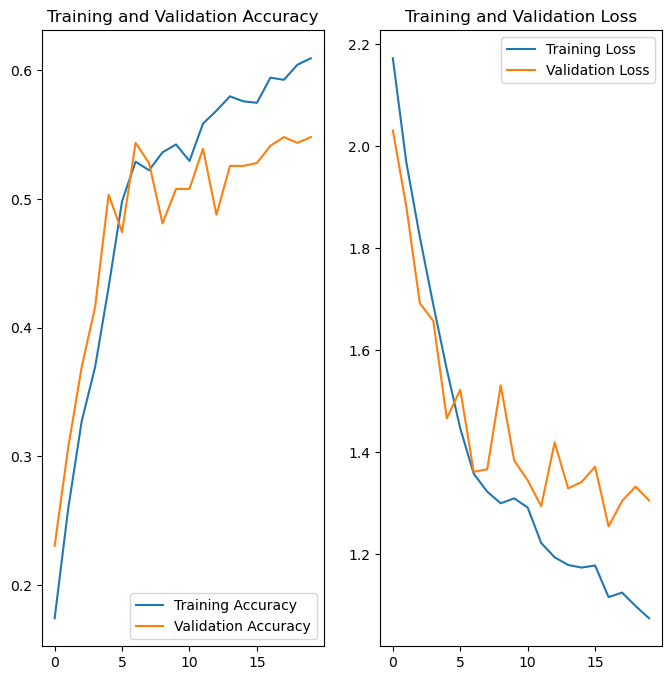

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [32]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [33]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,CNN_assignment/Train/melanoma/ISIC_0010550.jpg,melanoma
1,CNN_assignment/Train/melanoma/ISIC_0011128.jpg,melanoma
2,CNN_assignment/Train/melanoma/ISIC_0010587.jpg,melanoma
3,CNN_assignment/Train/melanoma/ISIC_0010034.jpg,melanoma
4,CNN_assignment/Train/melanoma/ISIC_0000555.jpg,melanoma
...,...,...
2234,CNN_assignment/Train/dermatofibroma/ISIC_00335...,dermatofibroma
2235,CNN_assignment/Train/dermatofibroma/ISIC_00270...,dermatofibroma
2236,CNN_assignment/Train/dermatofibroma/ISIC_00337...,dermatofibroma
2237,CNN_assignment/Train/dermatofibroma/ISIC_00338...,dermatofibroma


Class=3, n=438 (19.562%)
Class=5, n=462 (20.634%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)


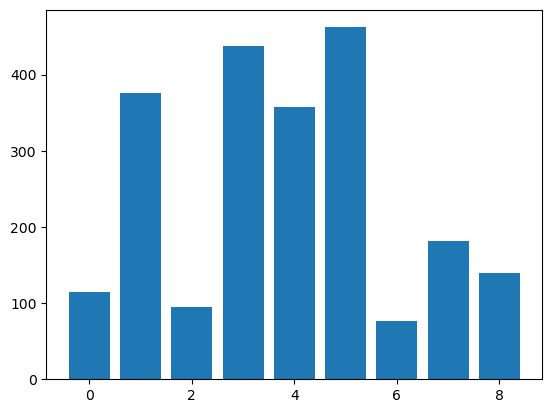

In [34]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset="CNN_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3163D4490>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3AEE8DB90>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 438 image(s) found.
Output directory set to CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x321979E10>: 100%|█


Initialised with 357 image(s) found.
Output directory set to CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2725x2082 at 0x3163D4810>: 100%|


Initialised with 462 image(s) found.
Output directory set to CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3AEDD4150>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x3A97F86D0>: 100%|█


Initialised with 181 image(s) found.
Output directory set to CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3219B8A50>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3AEDF8810>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010278.jpg_a4abfef0-b1f4-4fb6-b564-0636b338d745.jpg',
 'CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010609.jpg_81d3f656-506f-46a3-b10e-011cf73b9aa3.jpg',
 'CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0000487.jpg_cdc67484-02ea-47d5-947e-c8266e4d4f88.jpg',
 'CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0001127.jpg_afc93e6c-719d-4e56-8cee-66b1c0521b7c.jpg',
 'CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010145.jpg_192491f8-f963-4543-8934-9a09fb545e34.jpg',
 'CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0000139.jpg_43dbc070-91c4-4199-9aff-b34eb86598fe.jpg',
 'CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0001105.jpg_8f2e0ca3-932c-4eed-8329-552736c8f50e.jpg',
 'CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0011193.jpg_301feb41-b644-4d55-b320-18ea212b9a1b.jpg',
 'CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_00

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [42]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [43]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

/var/folders/j3/kvlk94993hd_tnf4j8qzx6bw0000gn/T/ipykernel_14638/390629722.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [44]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [46]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [49]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [51]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - accuracy: 0.2126 - loss: 2.0387 - val_accuracy: 0.4269 - val_loss: 1.4880
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.4337 - loss: 1.4727 - val_accuracy: 0.5471 - val_loss: 1.2492
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5423 - loss: 1.2337 - val_accuracy: 0.5828 - val_loss: 1.1608
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.6066 - loss: 1.0610 - val_accuracy: 0.6377 - val_loss: 1.0077
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.6938 - loss: 0.8439 - val_accuracy: 0.7053 - val_loss: 0.8477
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.7763 - loss: 0.6462 - val_accuracy: 0.7171 - val_loss: 0.8059
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.8170 - loss: 0.5083 - val_accuracy: 0.7758 - val_loss: 0.6622
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.8758 - loss: 0

#### **Todo:**  Visualize the model results

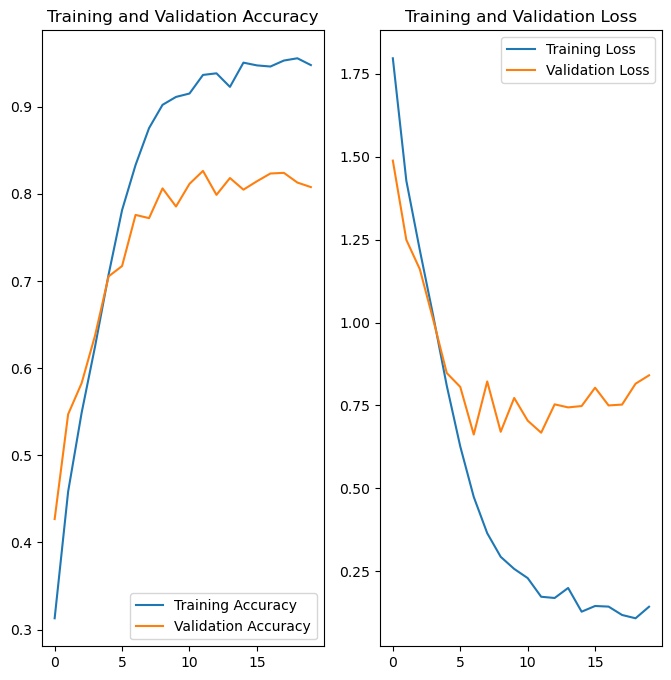

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [ ]:
As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.
As the training loss decreases with epochs the validation loss also decreases.
The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 75% accuracy on the validation set.
The difference in accuracy between training and validation accuracy is very less
Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 75%.